## 1. DataSet import

In [58]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *
from prepare_datasets import get_and_prepare_diabetes_dataset

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_prepare_diabetes_dataset()


X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 2. Model

In [59]:
from Model import NeuralNetwork

In [60]:
torch.manual_seed(42)
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [61]:
from sklearn.metrics import f1_score, accuracy_score

patience = 500
delta = 0.001
best_test_loss = float('inf')
counter = 0

epochs = 50000

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []
train_accuracies = []
test_accuracies = []


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train,
        y_pred=y_pred)
    accuracy_training = accuracy_score(y_true=y_train,
                                       y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test,
            y_pred=test_pred)
        accuracy_testing = accuracy_score(
            y_true=y_test,
            y_pred=test_pred)

    # early stopping
    if test_loss.item() < best_test_loss - delta:
        best_test_loss = test_loss.item()
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch} ")
            break

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)
    train_accuracies.append(accuracy_training)
    test_accuracies.append(accuracy_testing)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}%, Accuracy-Training: {accuracy_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%, Accuracy-Test: {accuracy_testing:.2f}%")


model.load_state_dict(best_model_state)

Epoch: 0 | Loss: 0.71946, F1-Training: 0.43%, Accuracy-Training: 0.35% | Test loss: 0.70456, F1-Testing: 0.29%, Accuracy-Test: 0.42%
Epoch: 100 | Loss: 0.53013, F1-Training: 0.56%, Accuracy-Training: 0.74% | Test loss: 0.62054, F1-Testing: 0.43%, Accuracy-Test: 0.65%
Epoch: 200 | Loss: 0.43905, F1-Training: 0.70%, Accuracy-Training: 0.81% | Test loss: 0.68279, F1-Testing: 0.44%, Accuracy-Test: 0.66%
Epoch: 300 | Loss: 0.29590, F1-Training: 0.83%, Accuracy-Training: 0.89% | Test loss: 0.81667, F1-Testing: 0.47%, Accuracy-Test: 0.67%
Epoch: 400 | Loss: 0.17349, F1-Training: 0.92%, Accuracy-Training: 0.95% | Test loss: 1.22869, F1-Testing: 0.42%, Accuracy-Test: 0.62%
Epoch: 500 | Loss: 0.09650, F1-Training: 0.96%, Accuracy-Training: 0.97% | Test loss: 1.75678, F1-Testing: 0.39%, Accuracy-Test: 0.62%
⏹️ Early stopping at epoch 545 


<All keys matched successfully>

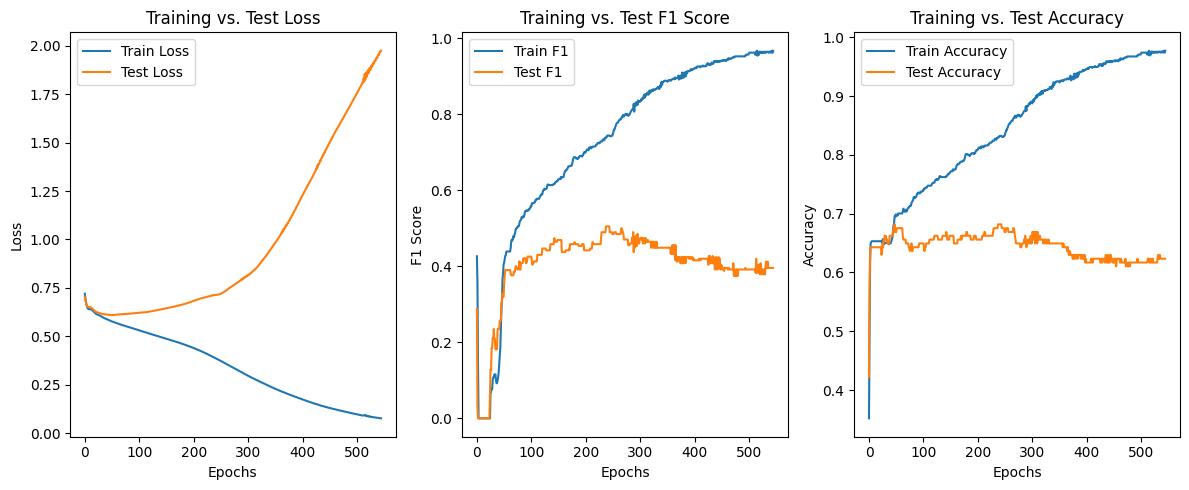

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# plot f1_score
plt.subplot(1, 3, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

# accuracies
plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Saving the model

In [63]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "diabetes_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
f=MODEL_SAVE_PATH)

Saving model to: models\diabetes_model_0.pth


## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [ ]:
lamda = 0.3
epochs = 7000
lr = 0.00001

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=lr)

train_losses = []
test_losses = []

for epoch in range(epochs):
    loaded_model.train()
    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)
    abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)

    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # evaluation
    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)

        test_loss = test_loss_1 - lamda * test_loss_2

        f1_score_test = f1_score(y_test, test_pred)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    # refresh classification split
    if epoch % 10 == 0:
        X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
        X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    # logging
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")


Epoch: 0| Train_Loss: -2.11396| Test loss: -0.44712| f1_score_test: 0.37895


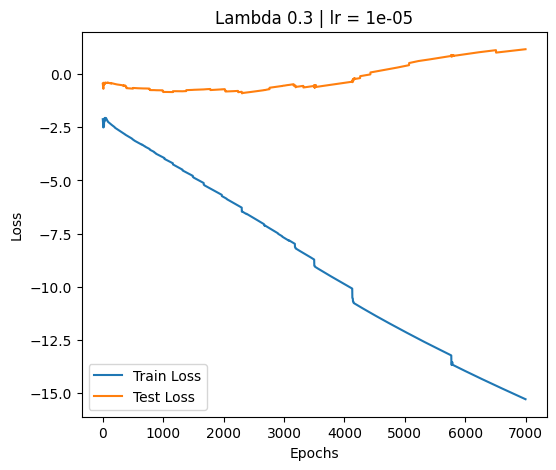

In [53]:
plt.figure(figsize=(6, 5))

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Lambda {lamda} | lr = {lr}")
plt.legend()

## Testing for different Lamdas



Training for lambda = 0.050
Epoch: 0| Train_Loss: -0.28956| Test loss: 1.58994| f1_score_test: 0.37895
⏹️ Early stopping at epoch 551 
⏹️ Best Test Loss  1.716706395149231 
⏹️ Best Epoch  51 
⏹️ Best_f1_score 0.367816091954023 


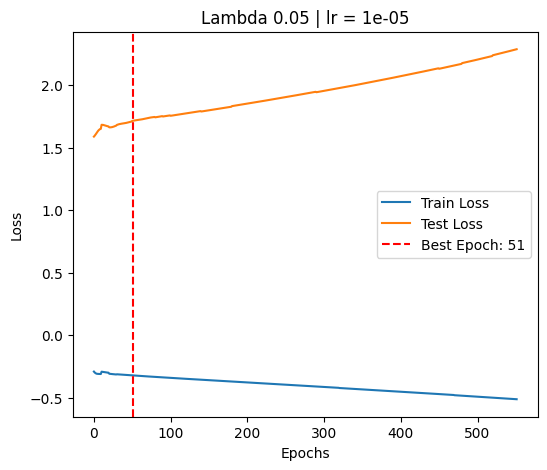


Training for lambda = 0.100
Epoch: 0| Train_Loss: -0.65444| Test loss: 1.18244| f1_score_test: 0.37895
⏹️ Early stopping at epoch 551 
⏹️ Best Test Loss  1.3569947481155396 
⏹️ Best Epoch  51 
⏹️ Best_f1_score 0.345679012345679 


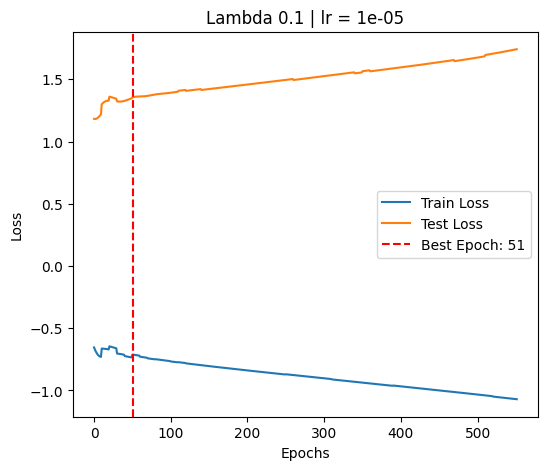


Training for lambda = 0.150
Epoch: 0| Train_Loss: -1.01932| Test loss: 0.77502| f1_score_test: 0.37895
⏹️ Early stopping at epoch 551 
⏹️ Best Test Loss  0.9485580921173096 
⏹️ Best Epoch  51 
⏹️ Best_f1_score 0.3037974683544304 


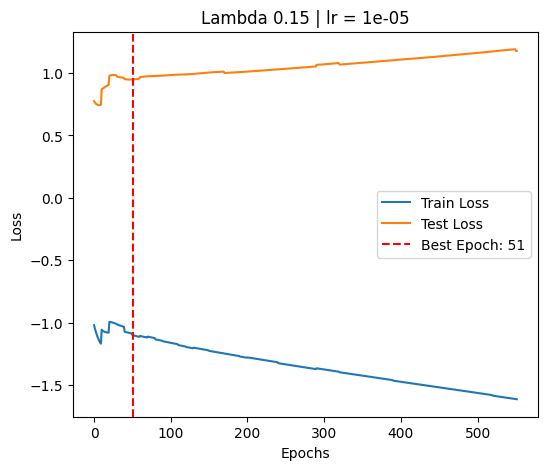


Training for lambda = 0.200
Epoch: 0| Train_Loss: -1.38420| Test loss: 0.36763| f1_score_test: 0.37895
⏹️ Early stopping at epoch 1062 
⏹️ Best Test Loss  0.507847785949707 
⏹️ Best Epoch  62 
⏹️ Best_f1_score 0.3076923076923077 


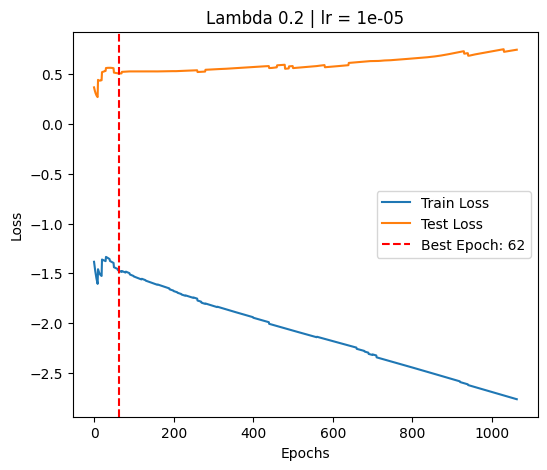


Training for lambda = 0.250
Epoch: 0| Train_Loss: -1.74908| Test loss: -0.03975| f1_score_test: 0.37895
⏹️ Early stopping at epoch 3216 
⏹️ Best Test Loss  0.025510787963867188 
⏹️ Best Epoch  216 
⏹️ Best_f1_score 0.3013698630136986 


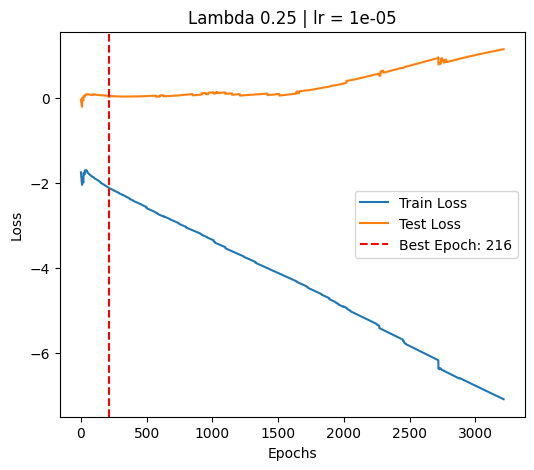


Training for lambda = 0.300
Epoch: 0| Train_Loss: -2.11396| Test loss: -0.44712| f1_score_test: 0.37895
⏹️ Early stopping at epoch 5107 
⏹️ Best Test Loss  -0.8325839042663574 
⏹️ Best Epoch  1107 
⏹️ Best_f1_score 0.3157894736842105 


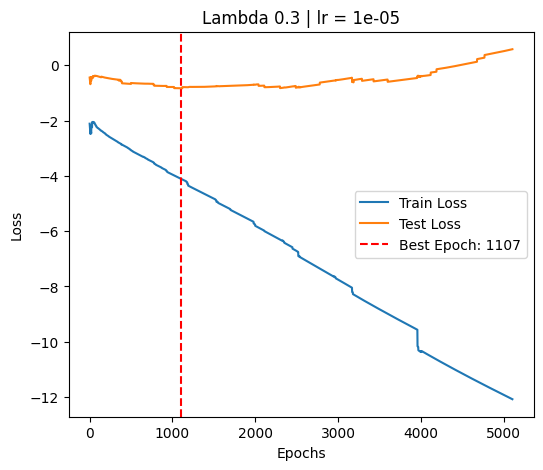

In [54]:
lambdas = [0.05,0.1,0.15,0.2,0.25,0.3]
lr = 0.00001
patiences = [500, 500, 500, 1000, 3000, 4000]
starting_epoch =50
delta = 0.001

model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)
models = [model1, model2, model3, model4, model5, model6]
best_f1_scores = []

for lamda, best_model, patience in zip(lambdas, models, patiences):
    epochs = 600000

    delta = 0.001
    best_test_loss = float('inf')
    counter = 0


    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


    X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
    X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr= lr)

    train_losses = []
    test_losses = []
    for epoch in range(epochs):

        # refresh classification split
        if epoch % 10 == 0:
            X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
            X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

        loaded_model.train()
        y_logits = loaded_model(X_train)
        y_pred = torch.argmax(y_logits, dim=1)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # evaluation
        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_pred = torch.argmax(test_logits, dim=1)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)
            test_loss = test_loss_1 - lamda * test_loss_2

            f1_score_test = f1_score(y_test, test_pred)


        train_losses.append(loss.item())
        test_losses.append(test_loss.item())


        # logging
        if epoch % 10000 == 0:
            print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

        if epoch > starting_epoch:
            # early stopping
            if test_loss.item() < best_test_loss - delta:
                best_test_loss = test_loss.item()
                best_epoch = epoch
                best_f1_score = f1_score_test
                counter = 0
                best_model_state = loaded_model.state_dict()
            else:
                counter += 1
                if counter >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch} ")
                    print(f"⏹️ Best Test Loss  {best_test_loss} ")
                    print(f"⏹️ Best Epoch  {best_epoch} ")
                    print(f"⏹️ Best_f1_score {best_f1_score} ")
                    best_f1_scores.append(best_f1_score)

                    plt.figure(figsize=(6, 5))

                    plt.plot(train_losses, label="Train Loss")
                    plt.plot(test_losses, label="Test Loss")
                    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Best Epoch: {best_epoch}")
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.title(f"Lambda {lamda} | lr = {lr}")
                    plt.legend()

                    plt.show()

                    break

    best_model.load_state_dict(best_model_state)


In [55]:
for (model, lamda) in zip(models, lambdas):
    model_save_path = f"models/diabetes_model_lambda_{lamda:.2f}.pth"
    torch.save(model.state_dict(), model_save_path)

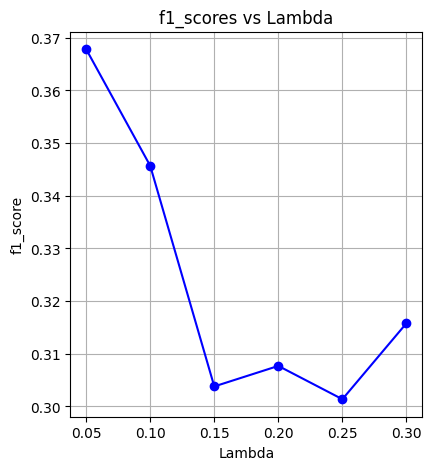

In [56]:
plt.figure(figsize=(10, 5))
# f1_score
plt.subplot(1, 2, 1)
plt.plot(lambdas, best_f1_scores, marker='o', color='blue')
plt.title("f1_scores vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("f1_score")
plt.grid(True)
